## Data cleaning
We have our 2 subreddits data that are already checked for duplicates.

Our steps to prepare our data for EDA and modeling are:

1. Combine title and selftext columns to form a compound text variable
2. Binarize our subreddit variable
3. Preprocess our text
4. Check for megathreads and other posts that are pseudo duplicates (different date, same title)
    - drop posts as necessary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from bs4 import BeautifulSoup

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
pd.options.display.html.use_mathjax = False

from wordcloud import WordCloud, STOPWORDS

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
# import our data
df_options = pd.read_csv('./data/options_topmonth.csv')
df_stocks = pd.read_csv('./data/stocks_topmonth.csv')

Let's double check that there are no duplicate entries left in our data. At the same time we'll examine how many posts have no selftext. These posts are likely to be image/media posts, which is why the selftext shows up empty. As long as there aren't too many of these, we can still get useful information by using the title of the post.

In [3]:
# check shape
df_options.shape

(999, 8)

In [230]:
# we drop using the subset of title and selftext. this makes pandas search for duplicates based on title first, then selftext.
# we see that our data remains the same shape, so no duplicates were found and nothing has to be dropped.
df_options.drop_duplicates(subset=['title','selftext'])

,author,downs,score,selftext,subreddit,title,ups,upvote_ratio
0,OnlyCallsForever,0.0,3308.0,"Hey guys, last week I lost $500k on 100s of $4...",options,"I am very down and depressed, lost 500k need s...",3308.0,0.95
1,UsedButtPlugsForSale,0.0,2552.0,Here is the [exhaustive list](https://twitter....,options,Meme stocks currently being shorted after GME ...,2552.0,0.96
2,corporatelifestory,0.0,2193.0,"When I started trading recently, I told myself...",options,I couldn’t control my greed today and lost a l...,2193.0,0.92
3,mastter1233,0.0,1864.0,Please mods do not delete this. This is a very...,options,Check your Tax Form on Robinhood. Robinhood is...,1864.0,0.98
4,OptionAlphaRob,0.0,1699.0,"Good morning, everyone! I'm very excited to an...",options,The Option Alpha Handbook,1699.0,0.98
...,...,...,...,...,...,...,...,...
994,Stonkybucs,0.0,3.0,So I have began tracking my trades for the las...,options,Stop Loss AHA Moments,3.0,0.64
995,srajeevan89,0.0,2.0,Noob here..\nI understand the call options and...,options,CRON call option.Suggestions please.,2.0,0.59
996,absloutemattness,0.0,3.0,"Hear me out, 7.6k investment into SENS gets me...",options,Am I stupid or does this work?,3.0,0.72
997,armorrig,0.0,3.0,Good evening fellas. Very new to options and h...,options,Covered Call for BB Rejected,3.0,0.72


In [5]:
df_stocks.shape

(992, 8)

In [6]:
# repeating the process for df_stocks
df_stocks.drop_duplicates(subset=['title','selftext'])

,author,downs,score,selftext,subreddit,title,ups,upvote_ratio
0,CriticDanger,0.0,21196.0,NaN,stocks,"Gamestop short interest just updated, it is no...",21196.0,0.92
1,electricp0ww0w,0.0,19990.0,"Forget the balance sheets, the financials , th...",stocks,Google street view should be one of your first...,19990.0,0.92
2,onlymadethistoupvote,0.0,19511.0,International brokers sued over naked short se...,stocks,"CIBC, Bank of America, UBS and TD Bank stand a...",19511.0,0.97
3,investstayhumble,0.0,16374.0,[https://www.cnbc.com/2021/03/06/covid-stimulu...,stocks,Breaking: US Senate votes to pass 1.9T pandemi...,16374.0,0.91
4,poison_ivey,0.0,14991.0,A colleague just started trading. I recommend...,stocks,If you want to be successful don’t get greedy....,14991.0,0.90
...,...,...,...,...,...,...,...,...
987,Spirited-Stick,0.0,17.0,I just learned a very expensive lesson today. ...,stocks,LPT. Learn market order types before you get i...,17.0,0.79
988,dbxyz,0.0,18.0,Rubicon Technology (RBCN) is a relatively forg...,stocks,DD for Rubicon Technology RBCN,18.0,0.85
989,Billy_The_Bookshelf,0.0,17.0,I'm a little bit confused about how the revers...,stocks,TLRY or APHA?,17.0,0.78
990,RLCStepResponse,0.0,18.0,What’s up with the low volume today? Kinda sus...,stocks,What’s up with the low volume today?,18.0,0.87


Both our datasets have no duplicates. 

### Null selftext values
Some subs are heavily geared towards media-based posts. For example, subs like r/pics or r/memes often don't see many text posts, as all their posts are typically images or videos. Having no selftext values makes it harder for us to train our model as there is less textual data to learn from. Let's see what proportion of posts in r/options and r/stocks have text in the post.

In [68]:
df_options['selftext'].isna().value_counts(normalize=True)

False    0.991992
True     0.008008
Name: selftext, dtype: float64

Not bad, a solid 99% of our posts have text in them. 

In [70]:
df_stocks['selftext'].isna().value_counts(normalize=True)

False    0.998992
True     0.001008
Name: selftext, dtype: float64

Let's combine our title and selftext into 1 column called all_text. This will be the column we use to train our model.

In [231]:
df_options['all_text'] = df_options['title'] + ' ' + df_options['selftext'].fillna('')
df_stocks['all_text'] = df_stocks['title'] + ' ' + df_stocks['selftext'].fillna('')

In [232]:
# check one of our dfs to make sure it worked
df_stocks[df_stocks['all_text'].notna()]

,author,downs,score,selftext,subreddit,title,ups,upvote_ratio,all_text
0,CriticDanger,0.0,21196.0,NaN,stocks,"Gamestop short interest just updated, it is no...",21196.0,0.92,"Gamestop short interest just updated, it is no..."
1,electricp0ww0w,0.0,19990.0,"Forget the balance sheets, the financials , th...",stocks,Google street view should be one of your first...,19990.0,0.92,Google street view should be one of your first...
2,onlymadethistoupvote,0.0,19511.0,International brokers sued over naked short se...,stocks,"CIBC, Bank of America, UBS and TD Bank stand a...",19511.0,0.97,"CIBC, Bank of America, UBS and TD Bank stand a..."
3,investstayhumble,0.0,16374.0,[https://www.cnbc.com/2021/03/06/covid-stimulu...,stocks,Breaking: US Senate votes to pass 1.9T pandemi...,16374.0,0.91,Breaking: US Senate votes to pass 1.9T pandemi...
4,poison_ivey,0.0,14991.0,A colleague just started trading. I recommend...,stocks,If you want to be successful don’t get greedy....,14991.0,0.90,If you want to be successful don’t get greedy....
...,...,...,...,...,...,...,...,...,...
987,Spirited-Stick,0.0,17.0,I just learned a very expensive lesson today. ...,stocks,LPT. Learn market order types before you get i...,17.0,0.79,LPT. Learn market order types before you get i...
988,dbxyz,0.0,18.0,Rubicon Technology (RBCN) is a relatively forg...,stocks,DD for Rubicon Technology RBCN,18.0,0.85,DD for Rubicon Technology RBCN Rubicon Technol...
989,Billy_The_Bookshelf,0.0,17.0,I'm a little bit confused about how the revers...,stocks,TLRY or APHA?,17.0,0.78,TLRY or APHA? I'm a little bit confused about ...
990,RLCStepResponse,0.0,18.0,What’s up with the low volume today? Kinda sus...,stocks,What’s up with the low volume today?,18.0,0.87,What’s up with the low volume today? What’s up...


Let's encode our our target column, `subreddit` to be 1 for options and 0 for stocks.

In [234]:
df_options['subreddit'] = df_options['subreddit'].map({'options':1})
df_stocks['subreddit'] = df_stocks['subreddit'].map({'stocks':0})

### Data processing
Now we'll take a closer look  at the text we are analyzing today. Of interest to us are words or phrases that frequently appear in either, or even both subs. The steps we need to take to prepare our data for this is as follows:

    1) Remove URLs
    2) Tokenize our text into individual words
    3) Remove stop words
        - these are words that appear frequently in the english language and do not provide useful information to us
    4) Lemmatize our tokens
        - this reduces words to their base lemma, allowing us to count different versions of the same word under 1 feature.
    5) Rejoin our tokens into a string

After this, we can run sklearn's CountVectorizer to produce a bag-of-words for each dataset. From there we can examine the frequency of the top x number of words that appear in each dataset, what are the differences in the most popular words between subreddits, and even if there are words that are frequent in both subreddits.

One thing to note is that generally in NLP tasks you want to remove digits, but here I am intentionally choosing to leave digits in my data for this project. My subreddits of choice are very 'quantitative' in nature, if you will, so I feel that I need to leave digits in to capture nuances that you can't otherwise. For example, I might be interested in knowing whether the 50 SMA or 200 SMA (Simple Moving Average) is the more popular charting indicator in r/stocks. If I remove digits, I won't be able to tell the differences between these 2 indicators. 

In [4]:
def get_wordnet_pos(word):
    """
    word is e.g. "model". pos_tag creates a list containing tuple(s) for whatever words it is passed.
    the output will be [('model', 'NN')], which indicates that model is a noun. 
    we extract the 'tag' to be used by calling output[0][1][0], which is ('model', 'NN') inside the list, and 'NN' inside
    the tuple, and 'N' inside the 'NN'. we map this to wordnet.NOUN, for e.g.
    we then return to the output of this function, the appropriate wordnet.TAG
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(raw_text, regex = r'\w+|[\d]+|\S+', lemma=True, sw=[]):
    """
    default tokenizer will split by whitespace. change regex to fit needs.
    this function WILL take very long to run if you allow it to lemmatize.
    default stopwords uses nltk's english stopwords. pass in a list of stopwords to sw if you want to add unique stopwords.
    """
    # remove html elements
    text = BeautifulSoup(raw_text).get_text()
    
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove punctuation
#     text = re.sub(r'[^a-zA-Z\d\$]',' ',text)    
    
    #convert all to lowercase and split, i.e. tokenize
#     words = text.lower().split()
    
#     # convert using tokenizer
    tokenizer = RegexpTokenizer(regex)
    words = tokenizer.tokenize(text.lower())
    
    # remove stopwords
    stops = set(stopwords.words('english') + sw)
    words_nostop = [w for w in words if w not in stops ]    
    
    # allow user to choose whether to lemma data or not
    if lemma:
        # lemma each word
        # this function gets the pos_tag for each word first, then tells the lemmatizer how to lemmatize each word
        # by calling the correct pos_tag. e.g. wordnet.VERB for a verb word, wordnet.ADJ for an adjective

        lemmatizer = WordNetLemmatizer()
        words_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words_nostop if w.isalnum()]
        return " ".join(words_lem)
    
    return " ".join(words_nostop)
    

In [95]:
raw_text = df_stocks.loc[3,'selftext']
text = BeautifulSoup(raw_text).get_text()
# words = text.lower().split()
tokenizer = RegexpTokenizer(r'\w+|\d+|\S+')
words = tokenizer.tokenize(text.lower())
words
[w for w in words if w.isalnum()]
# text = re.sub(r'[^a-zA-Z\d\$]',' ',text)
# text
# stops = set(stopwords.words('english') + [])
# lemmatizer = WordNetLemmatizer()
# words_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words if w.isalpha() and w not in stops]
# words_lem
# [w for w in words if w not in stops and w.isalpha()]

['the',
 'us',
 'senate',
 'just',
 'passed',
 'the',
 '1',
 'pandemic',
 'relief',
 'bill',
 'after',
 'negotiating',
 'with',
 'a',
 'centrist',
 'democrat',
 'for',
 'the',
 'final',
 'vote',
 'to',
 'break',
 'the',
 '50',
 'tie',
 'after',
 'a',
 'month',
 'of',
 'a',
 'downtrend',
 'in',
 'equities',
 'on',
 'friday',
 'markets',
 'rallied',
 'into',
 'the',
 'green',
 'i',
 'expect',
 'that',
 'this',
 'bill',
 'will',
 'likely',
 'be',
 'a',
 'catalyst',
 'that',
 'kicks',
 'markets',
 'off',
 'next',
 'week',
 'further',
 'into',
 'green',
 'territory',
 'as',
 'more',
 'households',
 'especially',
 'those',
 'who',
 'are',
 'making',
 'less',
 'than',
 '70k',
 'per',
 'year',
 'can',
 'anticipate',
 'a',
 '1400',
 'check',
 'in',
 'the',
 'coming',
 'weeks']

In [5]:
text_preprocessor(df_options.loc[101,'selftext'])

'edit mention intend use computer lot info setup lend well phone hence buddy mine building app also know build apps web stuff feel free try phone think experience well tldr see title plus change stock price since post give sense play leaderboard show best dd free idea base post suggest find good dd pumped yet work strategy site try check pumped stock pull stock price 50da 52 week high etc check recent news link number mention wsb etc also try pull stock price moment load page dd compare price retrieve time dd post see dd time set dd broken 3 section post number chatter click detail post see dd immediately click dd add note occassionally add tldr summary play dumb note box remind number section add symbol site dumb add automatically add basic stock price info foreign ticker right also leader board track dd do time see idea do best also add benchmark add new functionality recently listens new dd wsb run stock price check automatically add top list assume work need late post button always

In [153]:
df_options.loc[101,'selftext']

'EDIT: I should mention I intended this to be used on computers.  There\'s a lot of info and this setup doesn\'t lend itself very well to phones.  Hence why a buddy of mine is building an app.  Also, I don\'t know how to build apps, just web stuff.  Feel free to try it on a phone, but I think the experience is better on a \'puter. \n\n&amp;#x200B;\n\nTLDR; see title, plus % change in stock price since post gives a sense of how a play did.\xa0 Leaderboard shows best-performing DDs.\xa0 It\'s free.  \xa0\n\n\xa0[https://tendies-machine.herokuapp.com/](https://tendies-machine.herokuapp.com/)\n\n&amp;#x200B;\n\nThe idea is based on [this](https://www.reddit.com/r/SPACs/comments/k9savf/spac_picks_via_basic_search_analytics_google_vs) post, suggesting that finding good DD that hasn\'t been too pumped up yet can work as a strategy.\xa0 The site tries to check how pumped a stock is by pulling stock price, 50DA, 52 week high, etc., checking for recent news and it links to number of mentions on 

In [127]:
df_stocks.loc[3,'selftext']

'[https://www.cnbc.com/2021/03/06/covid-stimulus-update-senate-passes-1point9-trillion-relief-bill.html](https://www.cnbc.com/2021/03/06/covid-stimulus-update-senate-passes-1point9-trillion-relief-bill.html)\n\n&amp;#x200B;\n\nThe US Senate just passed the 1.9T pandemic relief bill after negotiating with a centrist Democrat for the final vote to break the 50-50 tie.\n\nAfter a month of a downtrend in equities, on Friday, markets rallied into the green.  I expect that this bill will likely be a catalyst that kicks markets off next week further into green territory as more households, especially those who are making less than 70k per year can anticipate a 1400 check in the coming weeks.'

In [128]:
# example of how the preprocessor works
text_preprocessor(df_stocks.loc[3,'selftext'])

'u senate pass 1 pandemic relief bill negotiate centrist democrat final vote break 50 tie month downtrend equity friday market rally green expect bill likely catalyst kick market next week green territory household especially make less 70k per year anticipate 1400 check come week'

While typically we might want to discard non-word characters when carrying out data processing for NLP tasks, in our case, digit characters are also quite an important part of discussion on r/options and r/stocks. As such, we will opt to leave them in for our EDA.

In [237]:
# run our datasets through the function. this will take a while if you allow lemmatization
# please wait for about 5 minutes.
df_options['all_text_clean'] = df_options['all_text'].map(text_preprocessor)
df_stocks['all_text_clean'] = df_stocks['all_text'].map(text_preprocessor)

We also know that subreddits often have an AutoModerator bot that regularly posts megathreads for people to engage with. These megathreads will often be titled something like "Megathread 2/26 Friday: Post your ideas here", and often have a very regular body of text, perhaps accompanied by some pertinent news links for the week. This means that while these posts are not exact duplicates of each other, they are very systematically similar in a way that may cause our model to overfit on these posts. We should remove these posts before conducting further analysis.
***
Apart from the AutoModerator bot, let's also check if there are any users that post threads similar to what the AutoModerator does.

In [238]:
df_options['author'].value_counts().head(10)

prostockadvice         16
hjyjustin              11
MoistBands              8
dobleman                7
MangoExternal           7
redtexture              7
Newtothepartay          5
nicefaygo               5
KRAndrews               5
RoastedChickenWings     4
Name: author, dtype: int64

In [239]:
df_options[df_options['author']=='hjyjustin'][['title','selftext','author']]

,title,selftext,author
112,02/18 Unusual Option Activity Summary,[02/18 UOA SUMMARY ](https://imgur.com/gallery...,hjyjustin
264,02/24 Unusual Option Activity Summary,[02/24 UOA Report ](https://i.imgur.com/Grb0Ea...,hjyjustin
317,03/01 Unusual Option Activity Summary,[03/01 UOA Report ](https://i.imgur.com/SS0t2H...,hjyjustin
396,02/16 Unusual Option Activity Summary,[02/16 UOA SUMMARY ](https://i.imgur.com/0zmLP...,hjyjustin
411,03/02 Unusual Option Activity Summary,[03/02 UOA Report ](https://i.imgur.com/66cscl...,hjyjustin
421,02/22 Unusual Option Activity Summary,[02/22 UOA Report ](https://i.imgur.com/RcscHl...,hjyjustin
448,02/19 Unusual Option Activity Summary,[02/19 UOA REPORT ](https://imgur.com/gallery/...,hjyjustin
479,02/25 Unusual Option Activity Data,[02/25 UOA Report ](https://i.imgur.com/jGx2IQ...,hjyjustin
506,03/05 Unusual Option Activity Summary,[03/05 UOA Report ](https://i.imgur.com/1zMZcA...,hjyjustin
611,02/17 Unusual Option Activity Summary,[02/17 UOA Report ](https://i.imgur.com/7v4puE...,hjyjustin


After looking through the posts from authors with multiple posts, I found that users u/hjyjustin and u/redtexture post regularly scheduled posts with a consistent title/selftext formatting. u/redtexture is actually a mod of r/options, which explains why he is in charge of some of these regular posts. We will drop posts from these authors.

In [184]:
df_stocks['author'].value_counts().head(10)

AutoModerator         38
coolcomfort123        16
bigbear0083           15
gorays21              10
psychotrader00         9
theepicone111          7
hooman_or_whatever     6
No_Seesaw1134          5
StarksTwins            5
ilai_reddead           5
Name: author, dtype: int64

In [197]:
df_stocks[df_stocks['author']=='theepicone111'][['title','selftext','author']]

,title,selftext,author
267,How long can ARK momentum continue?,I understand it’s an actively managed fund but...,theepicone111
390,What’s easier? 10k to 100k or 100k to 1mil?,\nWhich is easier and why? Assuming same acces...,theepicone111
484,XPENG set to run?,XPENG has seen a high of $74.49 after a steep ...,theepicone111
561,Aggressive investing / trading,I’m young (19). I have no debt to pay for at l...,theepicone111
616,ARK Israel Innovative Technology ETF,Was browsing ARK website and found this ETF I ...,theepicone111
667,Whats the reason for the lack of growth outsid...,A lot of the indices outside the US have under...,theepicone111
865,Good time to buy AAPL calls?,I’m looking at buying calls expiring January 2...,theepicone111


I found that apart from AutoModerator, the user u/bigbear0083 also regularly posts these kinds of regularly scheduled, consistent title/selftext formatted posts. We will drop his posts along with AutoModerator's.

In [240]:
# drop all posts by author 'bigbear0083' and AutoModerator from r/stocks, 
# and those by author 'redtexture' and 'hjyjustin' from r/options
df_options.drop(index=df_options[df_options['author'] == 'redtexture'].index, inplace=True)
df_options.drop(index=df_options[df_options['author'] == 'hjyjustin'].index, inplace=True)
df_stocks.drop(index=df_stocks[df_stocks['author'] == 'bigbear0083'].index, inplace=True)
df_stocks.drop(index=df_stocks[df_stocks['author'] == 'AutoModerator'].index, inplace=True)

## Exploratory Data Analysis
### Visualizing our most common words
Let's instantiate our bag-of-words from each df into a DataFrame of their own.

In [241]:
# we'll just set this to be the top 1000 features seen in each dataset
cvec = CountVectorizer()
options_words = pd.DataFrame(cvec.fit_transform(df_options['all_text_clean']).todense(),
                             columns=cvec.get_feature_names())
stocks_words = pd.DataFrame(cvec.fit_transform(df_stocks['all_text_clean']).todense(),
                             columns=cvec.get_feature_names())

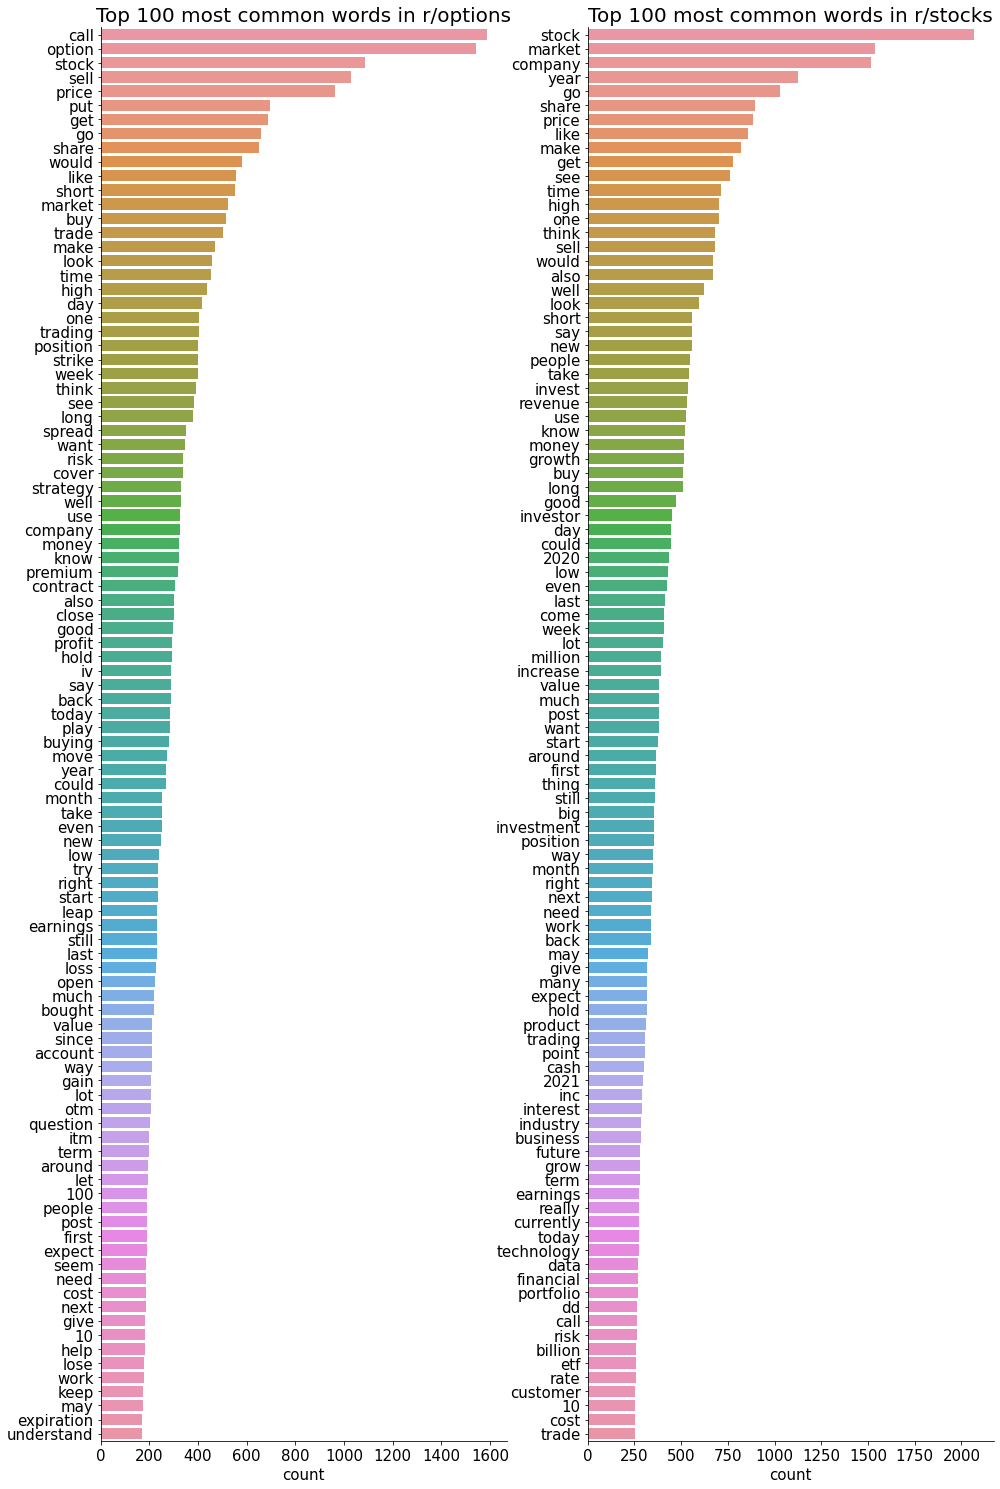

In [242]:
# look at top 100 words for each sub
top100_options = pd.DataFrame({'count': options_words.sum().sort_values(ascending=False).head(100)})
top100_stocks = pd.DataFrame({'count': stocks_words.sum().sort_values(ascending=False).head(100)})


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,26))
g = sns.barplot(data = top100_options, x='count', y=top100_options.index, ax=ax1)
h = sns.barplot(data = top100_stocks, x='count', y=top100_stocks.index)
g.set_title('Top 100 most common words in r/options',fontsize=20)
h.set_title('Top 100 most common words in r/stocks',fontsize=20)
g.tick_params(axis='both', labelsize=15)
h.tick_params(axis='both', labelsize=15);

Before going any further, we notice that there are some words featured here that either aren't useful at all or shouldn't be used for classification. Obviously, a subreddit called options will feature the word options frequently, and same for the stocks subreddit. In addition we notice some weird token artifacts like x200b, http, and www, which we know to be either from links or reddit's own markdown formatting. We want to add these words into our own list of stop words to remove them from the training model.

In [243]:
sw = ['stock','option','stocks','options']

From here on, whenever we iterate our EDA process to finetune our stop words, we can actually opt to pass our new stopwords directly into the stop_words argument in CountVectorizer. This has a couple of advantages. 

1. We don't need to reprocess our data from scratch every cycle, which saves time.
2. Since CountVectorizer returns features to us based on our lemmatized text, we only know the lemmatized versions of the new stopwords. Our preprocesssor lemmatizes AFTER removing the base set of stopwords, so it may not catch all variants of our stopwords at the beginning. Putting our NEW stopwords into CountVectorizer acts as a second layer of processing where we can catch stopwords AFTER lemmatization.

In [244]:
cvec = CountVectorizer(stop_words=sw,)
options_words = pd.DataFrame(cvec.fit_transform(df_options['all_text_clean']).todense(),
                             columns=cvec.get_feature_names())
stocks_words = pd.DataFrame(cvec.fit_transform(df_stocks['all_text_clean']).todense(),
                             columns=cvec.get_feature_names())

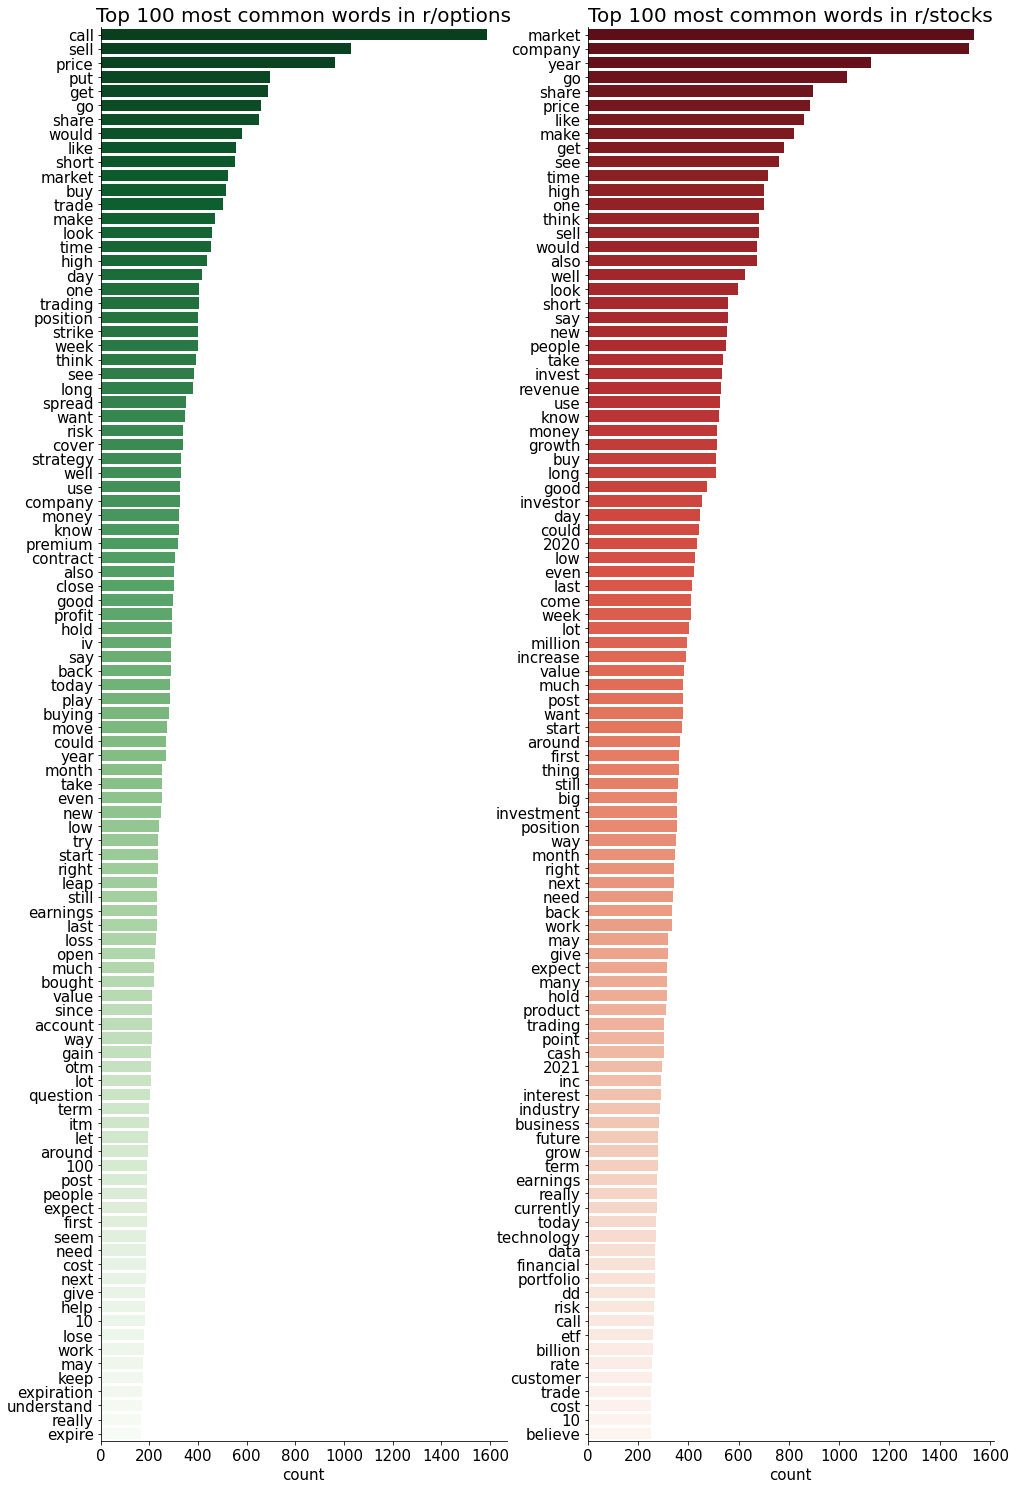

In [245]:
# look at top 100 words for each sub
top100_options = pd.DataFrame({'count': options_words.sum().sort_values(ascending=False).head(100)})
top100_stocks = pd.DataFrame({'count': stocks_words.sum().sort_values(ascending=False).head(100)})


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,26))
g = sns.barplot(data = top100_options, x='count', y=top100_options.index, ax=ax1, palette = 'Greens_r')
h = sns.barplot(data = top100_stocks, x='count', y=top100_stocks.index, palette = 'Reds_r')
g.set_title('Top 100 most common words in r/options',fontsize=20)
h.set_title('Top 100 most common words in r/stocks',fontsize=20)
g.tick_params(axis='both', labelsize=15)
h.tick_params(axis='both', labelsize=15);

As expected from r/options, a subreddit based on financial derivatives of shares, the top words include contract specific terms like `call`, `put`, `strike`, `iv` etc. Top words from r/stocks tend to focus more on overall market and/or company fundamentals, for example `revenue`, `growth`, `future`, `invest`. Some words that are common to BOTH subs include `market`, `price`, and `sell`, which are quite generic words that aren't options or stocks specific.


This is in line with what we know about options vs shares traders. Options traders tend to be highly focused on shorter term technical analysis. They can make money even on companies that do not represent a good long-term investment, simply because they can trade based on option flow. Long-term investors on the other hand tend to invest much more heavily in shares than options, and as such they are concerned more with long-term fundamental prospects of the company. This is reflected in the trend of words frequently encountered in both subreddits.

One interesting observation is that in r/options, the feature `day` appears more often than `year`, while in r/stocks it is the other way round. Options traders often view their holding period in terms of days, like a contract they own might be 7 days to expiration. In contrast, stock traders will often look at certain classes of stocks as longer-term holdings. Stocks like Apple, Amazon, and the like are stocks that traders want to hold on to for years because of their growth potential.
***
Let's push this analysis further. While the individual words alone tells us a lot already, we should also consider 2 or 3 word phrases. For example, some commonly used terms and phrases used in the trading community include`earnings season`, `cost basis` and so on. CountVectorizer has a parameter that lets us set the range of the n-gram returned by it. An n-gram is a feature that is made up of n tokens. Thus, we can set CountVectorizer to look at 2-grams and 3-grams, and plot the top terms like what we did above.

In [246]:
# look at top 20 2-grams for each sub
def ngram_plot(ngram, n_features):
    cvec = CountVectorizer(stop_words=sw, ngram_range=(ngram, ngram))
    options_words = pd.DataFrame(cvec.fit_transform(df_options['all_text_clean']).todense(),
                                 columns=cvec.get_feature_names())
    stocks_words = pd.DataFrame(cvec.fit_transform(df_stocks['all_text_clean']).todense(),
                                 columns=cvec.get_feature_names())

    top_options = pd.DataFrame({'count': options_words.sum().sort_values(ascending=False).head(n_features)})
    top_stocks = pd.DataFrame({'count': stocks_words.sum().sort_values(ascending=False).head(n_features)})


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))
    g = sns.barplot(data = top_options, x='count', y=top_options.index, ax=ax1, palette = 'Greens_r')
    h = sns.barplot(data = top_stocks, x='count', y=top_stocks.index, ax=ax2, palette = 'Reds_r')
    g.set_title('Top {} most common {}-gram in r/options'.format(n_features, ngram),fontsize=20)
    h.set_title('Top {} most common {}-gram in r/stocks'.format(n_features, ngram),fontsize=20)
    g.tick_params(axis='both', labelsize=15)
    h.tick_params(axis='both', labelsize=15)
    plt.tight_layout();

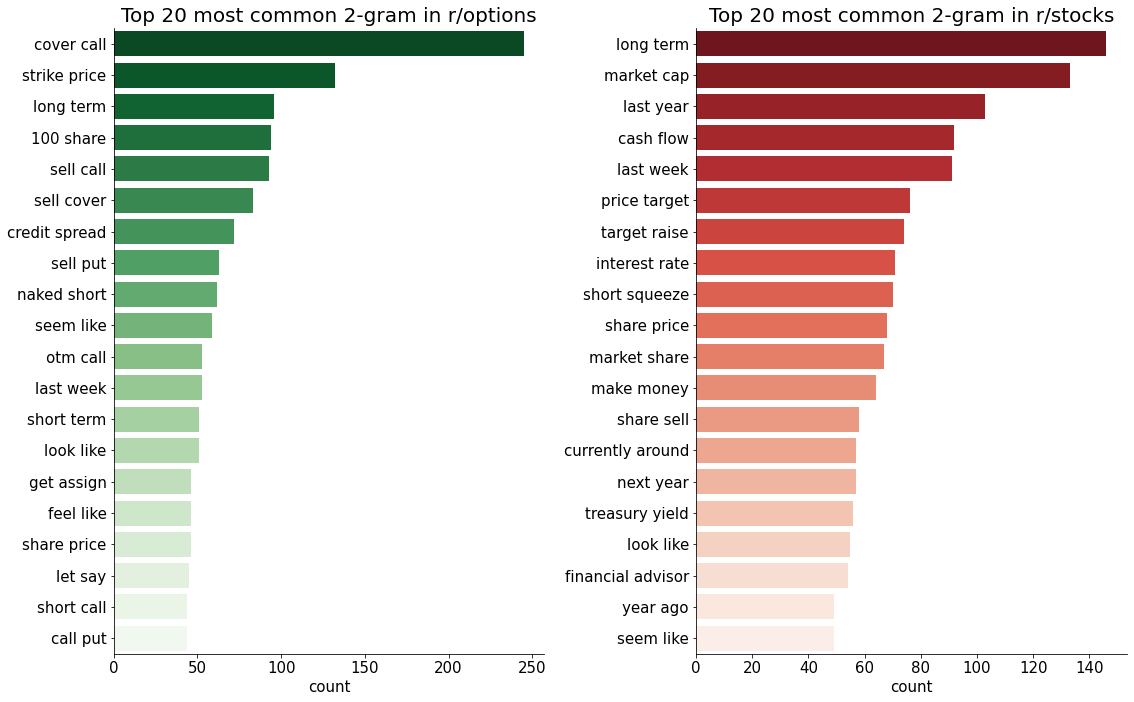

In [247]:
# top 20 2-grams
ngram_plot(2, 20)

Once again, we see that r/options participants use a lot of option unique terminology. 'credit spread' and 'otm call' are terms that are not used in stock trading for example. Our 2-grams for r/stocks show that higher-level, fundamental concepts to investing are more prevalent. For example we see terms like 'long term', 'price target', 'treasury yield', which all point to more 'traditional' styles of investing/trading. To elaborate, the term 'price target' is a metric many analysts use when publishing research on a company, and states their position on what they feel the company should be valued as some time in the future. It is often a hotly contested metric, but is one that stock traders are interested in when deciding on whether to enter into a position. The term 'treasury yield' refers to the US 10 yr treasury yield, which is the returns provided by the US 10 yr treasury bonds. Investors often take note of what the yield is because the rising yields tend to negatively impact certain classes of stocks, like tech stocks. This once again is a form of broader market fundamental analysis that is more typical of stocks than option traders.

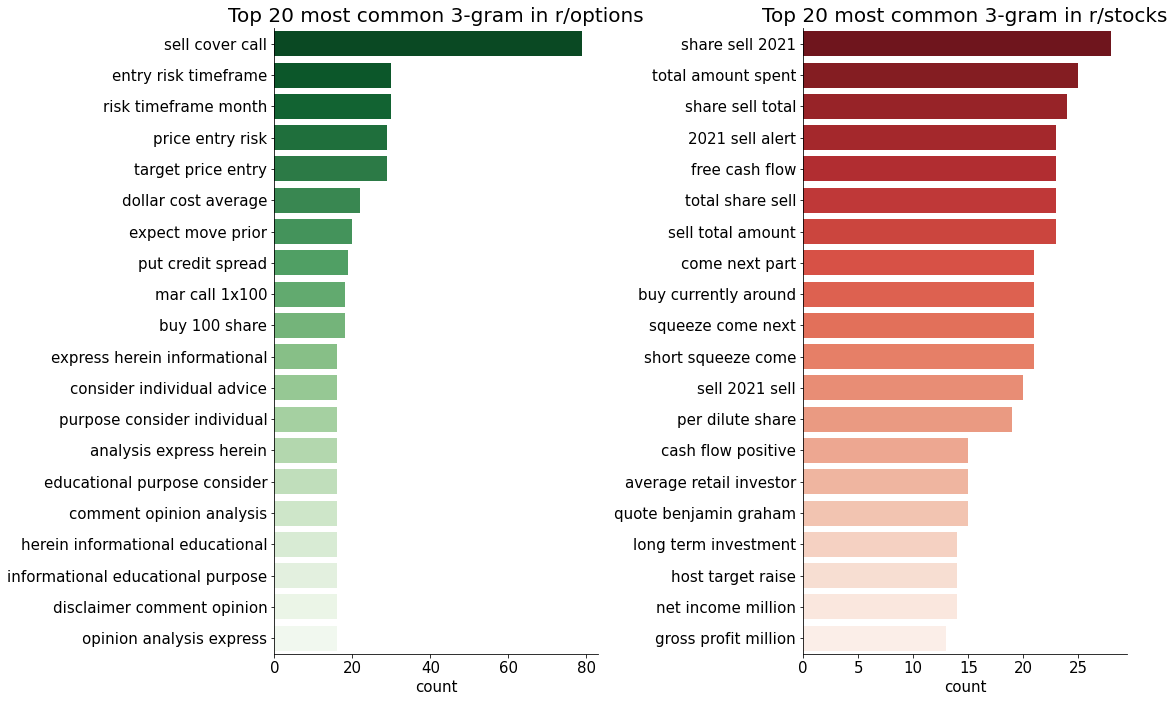

In [248]:
# top 20 3-grams
ngram_plot(3, 20)


Our 3-gram plots are likewise quite informative. We see a rather funny trend in r/options where people are using phrases like 'individual advice recommendation', 'disclaimer comment opinion' and such, which is something people do to absolve themselves from any liability. Upon checking, the user u/prostockadvice has many of these posts where these phrases appeared. However, his posts are actually quite distinct from each other, as he discusses different things that happened to him the previous day, and as such represent real discussion, which we want to keep. Apart from that, we also note that terms like 'put credit spread', 'sell cover cajll', and 'buy 100 share' appear frequently. These are all types of option trading strategies, or subsets of them. For example, selling a covered call often requires one to simultaneously buy 100 shares as part of the strategy. We can thus see that this particular strategy seems to be a popular topic of discussion among options traders.

Our 3-grams for r/stocks once again show that stock traders engage in discussions on fundamental metrics of companies. Terms like 'per dilute share', 'cash flow positive', 'net income million' and 'free cash flow' are often used into company quarterly reports when they report their companies financial health to investors. This shows that stock traders read and discuss these reports, and subsequently these metrics when engaging in discussions with other traders because they use these metrics to inform their trading thesis. 

In [249]:
# take a final look at the resultant shapes of our datasets
print('df_options shape: {}'.format(df_options.shape))
print('df_stocks shape: {}'.format(df_stocks.shape))

df_options shape: (981, 10)
df_stocks shape: (939, 10)


### Visualizing word counts per post
Let's look how the distribution of word counts per post across both subreddits. Since we've already processed our data, we'll take the word count from our 'all_text_clean' column, as it contains the most relevant information. We'll ignore posts with above 2000 word count as these are mostly outliers.

In [250]:

def wordcount(text):
    words = text.split()
    return len(words)
df_options['wordcount'] = df_options['all_text_clean'].map(wordcount)
df_stocks['wordcount'] = df_stocks['all_text_clean'].map(wordcount)

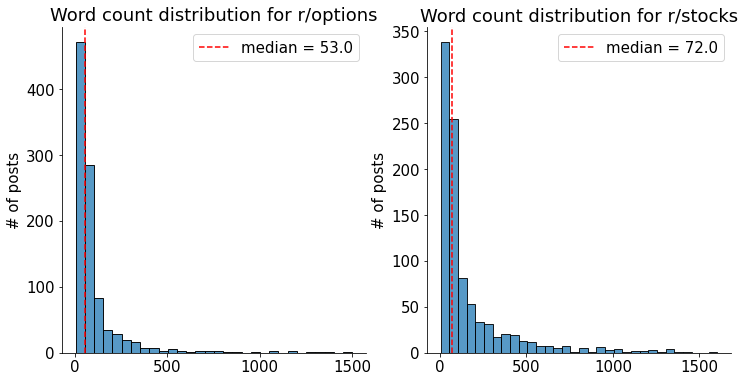

In [251]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
g = sns.histplot(data=df_options[df_options['wordcount']<2000], x='wordcount', binwidth=50, ax=ax1)
g.set_title('Word count distribution for r/options'), g.set_xlabel(''), g.set_ylabel('# of posts')
g.axvline(df_options['wordcount'].median(), linestyle='dashed', color='r', 
          label= 'median = {}'.format(df_options['wordcount'].median()))
g.legend()
                                 
h = sns.histplot(data=df_stocks[df_stocks['wordcount']<2000], x='wordcount', binwidth=50, ax=ax2)
h.set_title('Word count distribution for r/stocks'), h.set_xlabel(''), h.set_ylabel('# of posts')
h.axvline(df_stocks['wordcount'].median(), linestyle='dashed', color='r', 
          label= 'median = {}'.format(df_stocks['wordcount'].median()))
h.legend();

Posts in stocks tend to be longer than posts in options. While it cannot be said that the quality of discussion in r/stocks in definitely higher than in r/options, it does suggest that posts there are generally more substantial in content, and are less likely to be short posts that ask for opinions, for example 

    Hey guys, I saw this ticker $OCGN that had increased volume yesterday, any thoughts?
    
Let's take a look at some examples of really short posts.

In [252]:
for x in df_options[df_options['wordcount'] <50]['all_text_clean'].sample(5, random_state=49):
    print(x)
    print('----')

buying dip grwg look caught overall sell continue mot consistent performer portfolio buying dip since couple day ago dominate mmj grower market fuck walmart weed retail
----
call expire money call expire money still pay premium expires
----
strategy hedge market correction market wobbly past couple week realize market correction hedge portfolio think play vix reading large difference spot future price make challenge play also look maybe put debit spread spy qqq type strategy ya try
----
seek help hi guy new option trader excite show loss porn blow 400k account get first trade picked course gme premium crazy high guy use kind technical option analysis try premium favor
----
call free money right guy think call january 2022 seem like rebound close make money make pre pandemic stock range since 2009 171 contract average trend currently huge gap fill take look let know wrong please thank
----


As we can see, short posts could comprise of really succinct trading thesis statements, or they could be requests for advice. These type of posts represent about 40% of all posts we mined from r/options. But are they necessarily the most engaging posts? Let's look at the relationship between word count and upvotes to see whether more substantial posts see more engagement and approval. 

<AxesSubplot:xlabel='wordcount', ylabel='ups'>

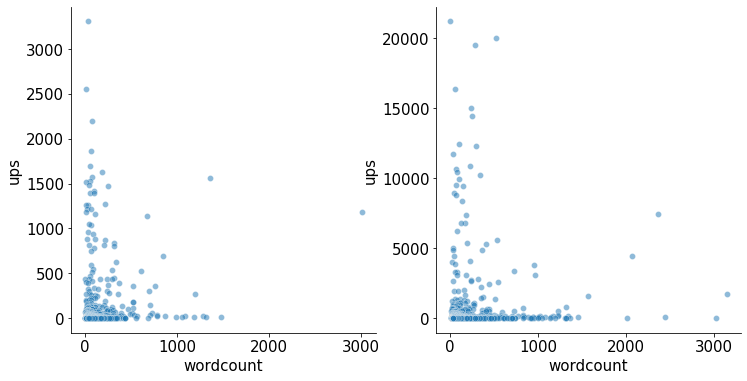

In [253]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=df_options, x='wordcount', y='ups', alpha=0.5, ax=ax1)
sns.scatterplot(data=df_stocks, x='wordcount', y='ups', alpha=0.5, ax=ax2)

No clear relationship appears between word count and upvotes. We do see however, that posts that see extremely high engagement are almost always on the shorter side. This likely indicates that extra wordy posts tend to not be so popular with users, as we can see by the long bar of dots along the bottom of the y-axis.

### Visualizing the most popular words via wordclouds
Wordclouds are a fun, alternative way to visualize the frequency of words that appear in a corpus of text. We can use this simply to supplement our intuition about our chosen subreddits.

In [254]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

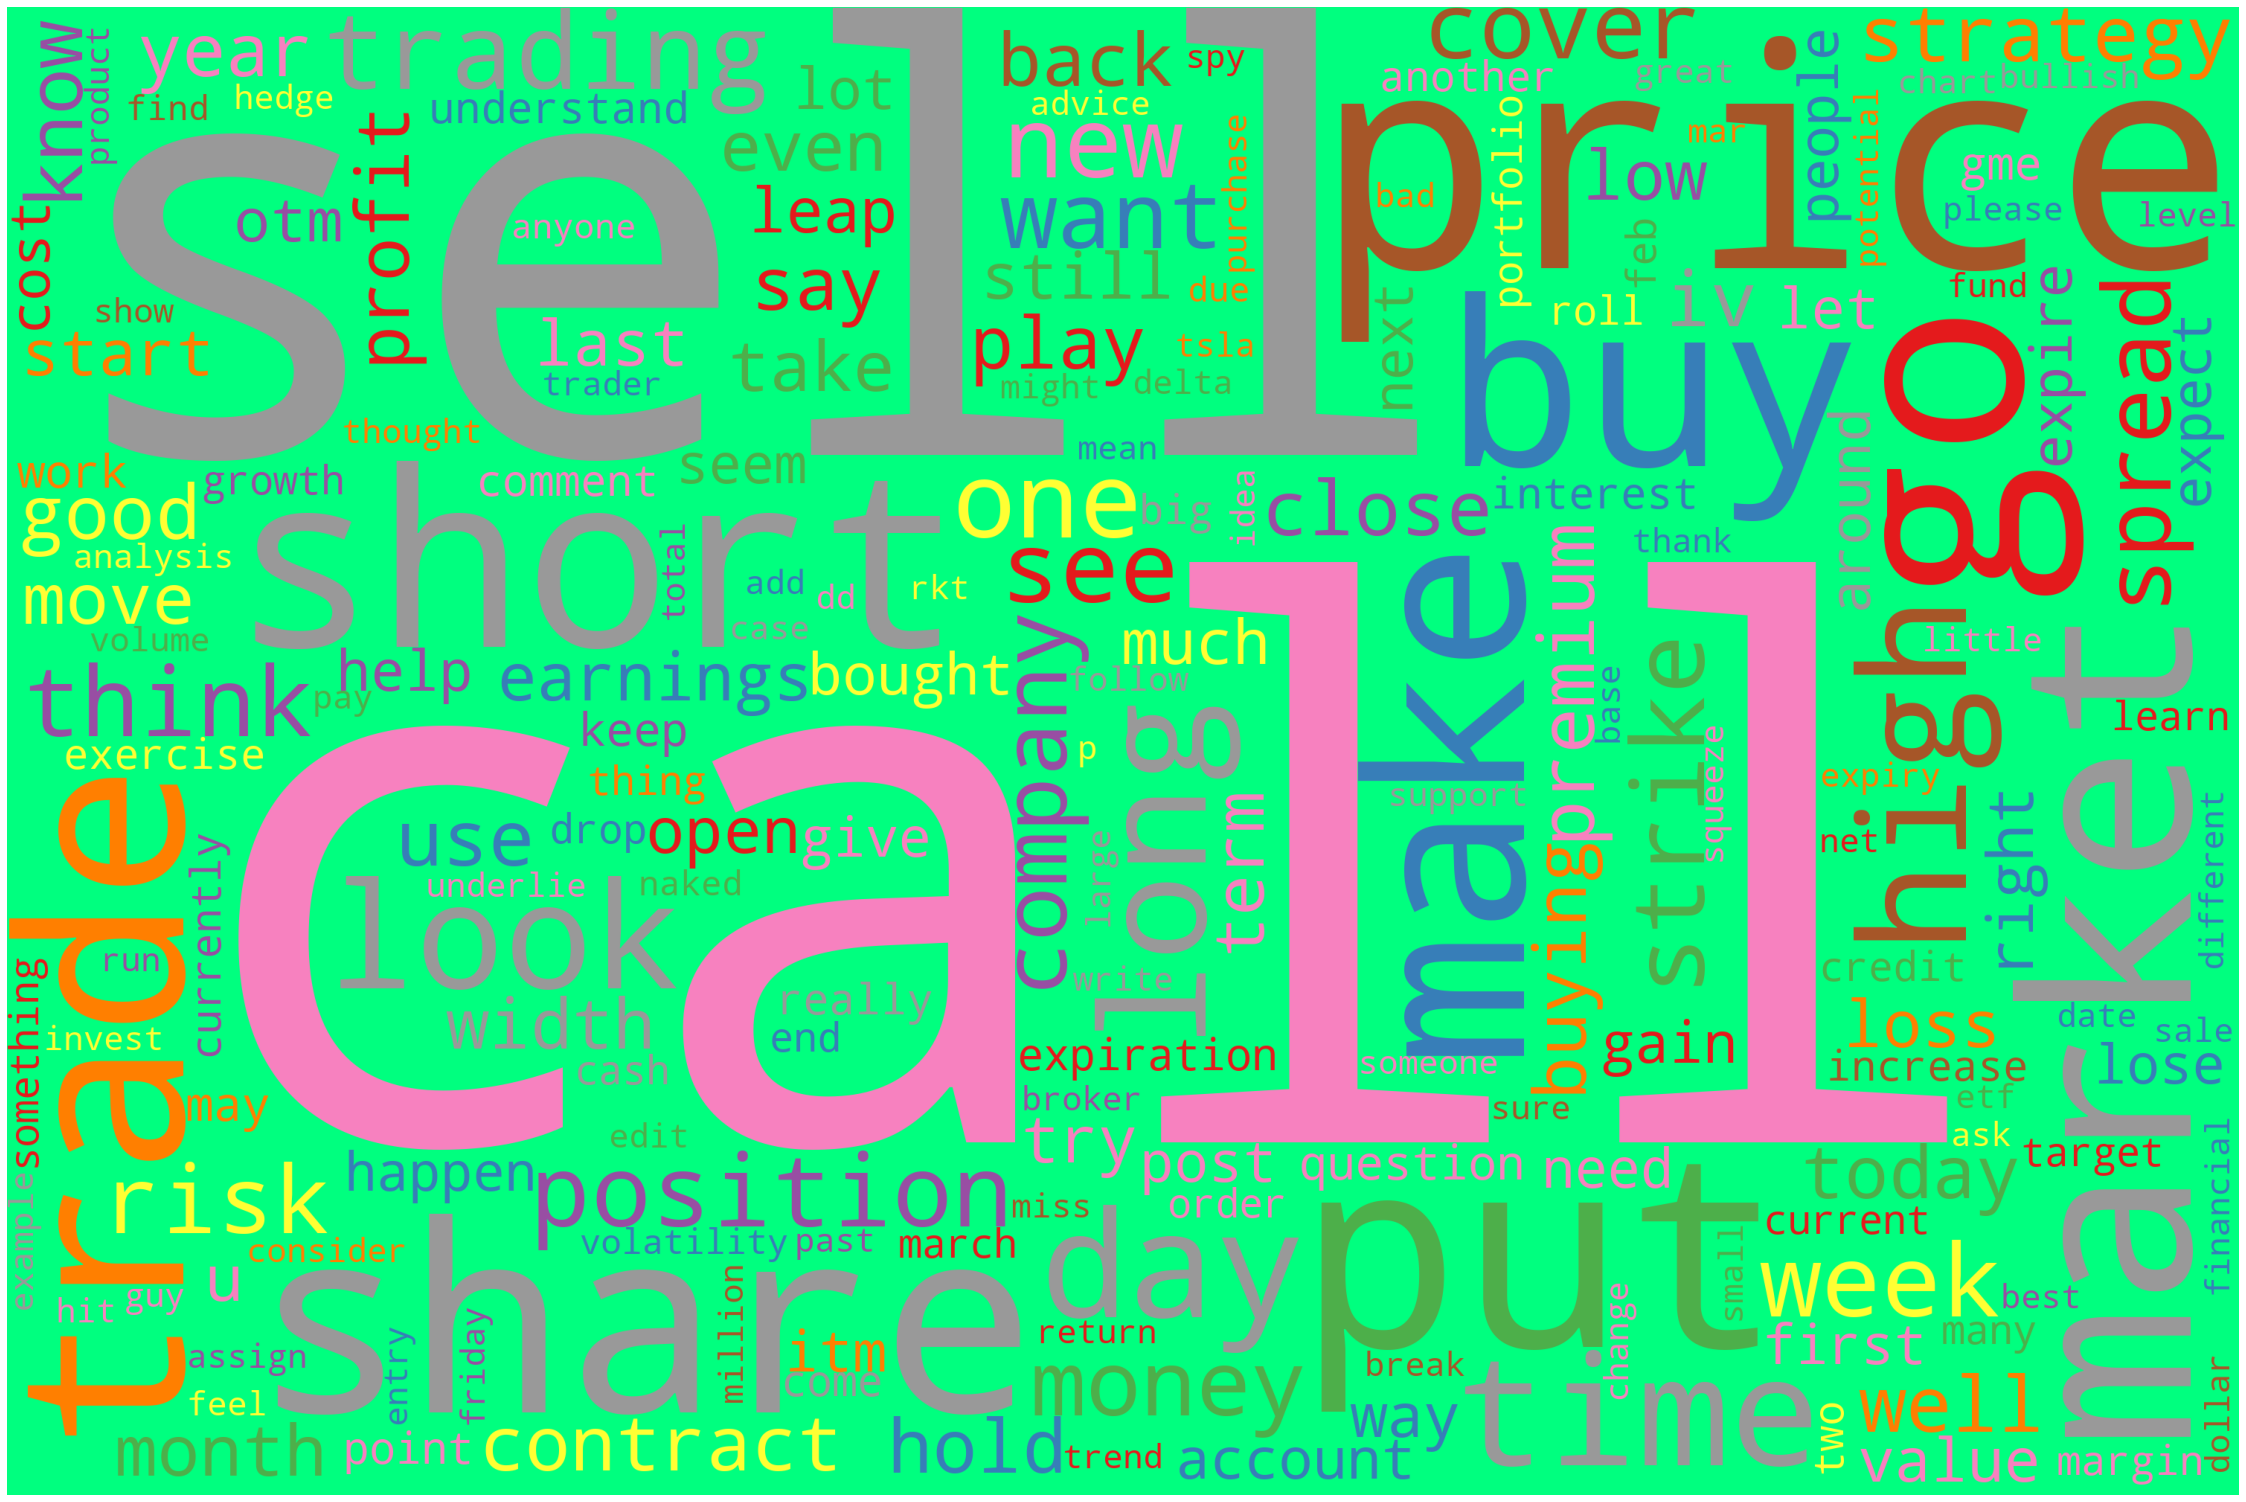

In [142]:
# Generate word cloud for r/options
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='springgreen', colormap='Set1', 
                      collocations=False,stopwords = STOPWORDS).generate(df_options['all_text_clean'].sum())
# Plot
plot_cloud(wordcloud)

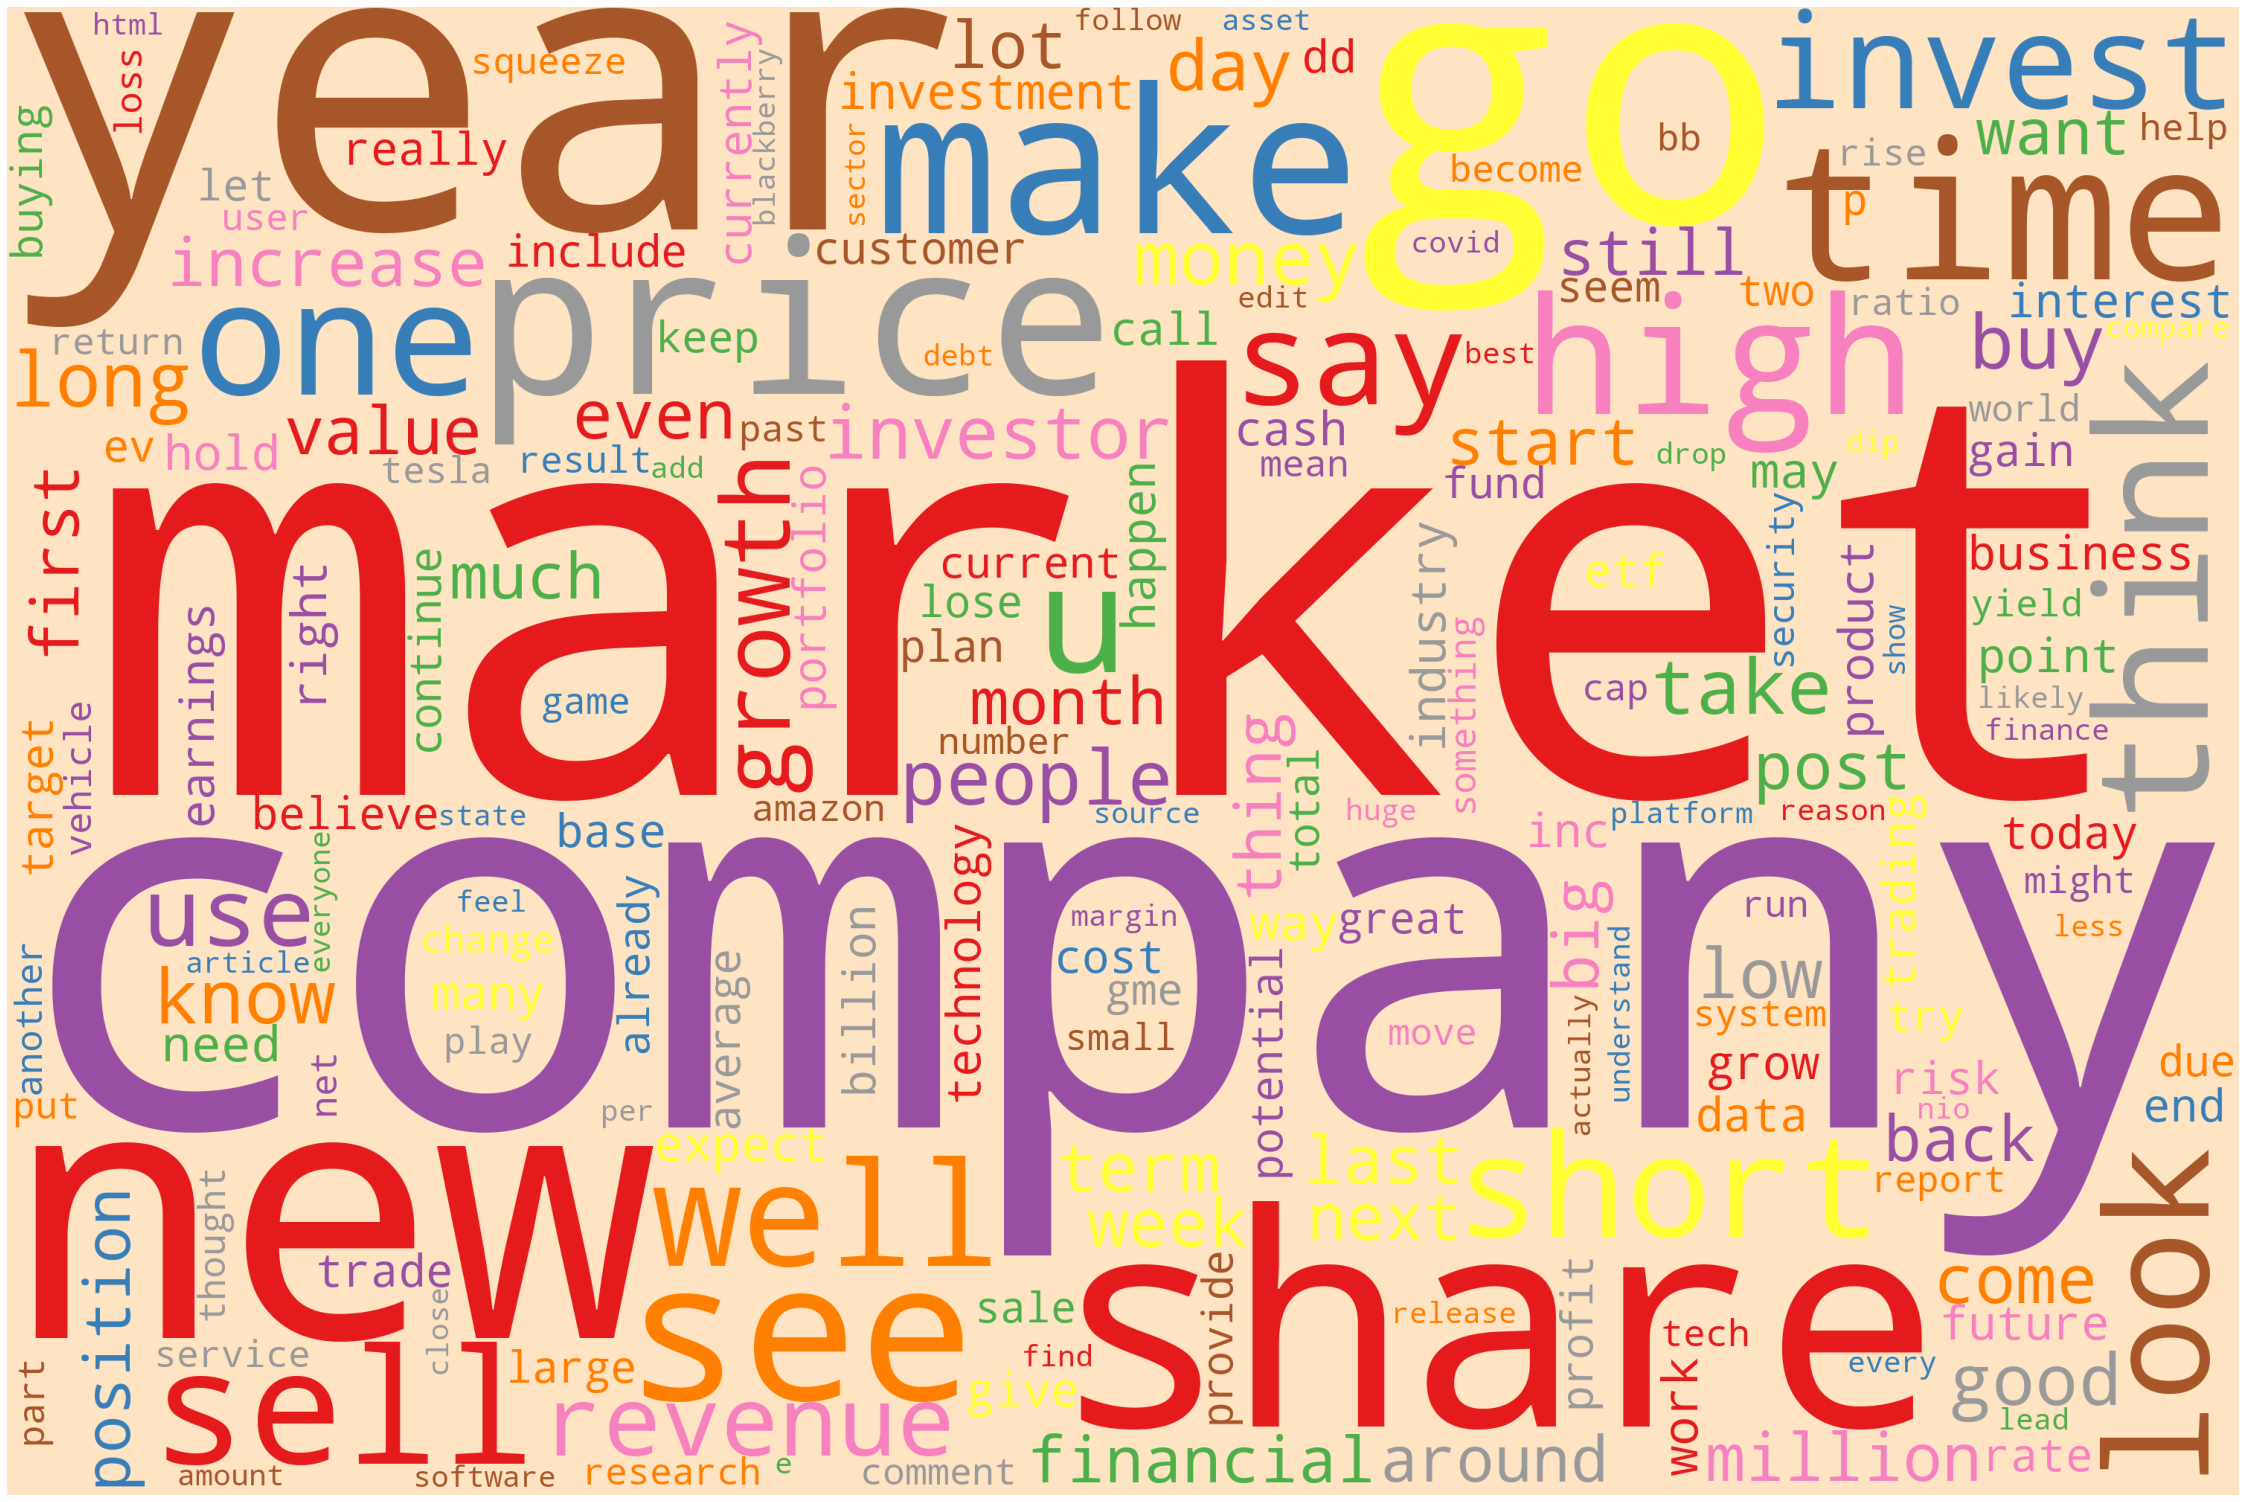

In [143]:
# Generate word cloud for r/stocks
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='bisque', colormap='Set1', 
                      collocations=False,stopwords = STOPWORDS).generate(df_stocks['all_text_clean'].sum())
# Plot
plot_cloud(wordcloud)

### Visualizing post engagement
One way to estimate post engagement is to look at the number of upvotes a post has. A post that sees greater reach will likely have a higher number of upvotes as more people interact with it. Let's see how our subreddits compare.

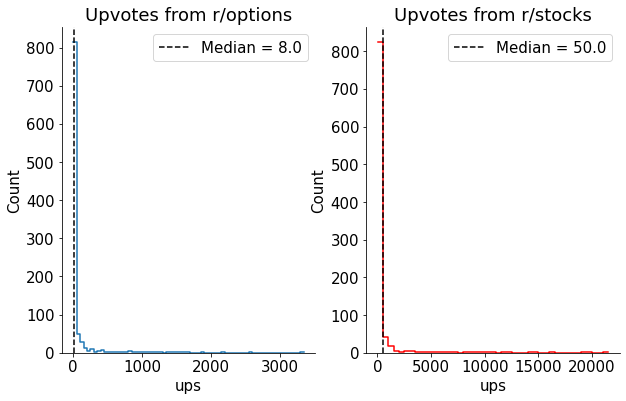

In [255]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data=df_options['ups'], element='step', alpha=0.5, fill=False, binwidth=50, ax=ax1)
ax1.set_title('Upvotes from r/options')
ax1.axvline(df_options['ups'].median(), linestyle='--',color='black', label='Median = {}'\
            .format(round(df_options['ups'].median(), 0)))
ax1.legend()
sns.histplot(data=df_stocks['ups'], element='step', alpha=0.5, color='red', fill=False, binwidth=500, ax=ax2)
ax2.axvline(df_stocks['ups'].mean(), linestyle='--',color='black', label='Median = {}'\
            .format(round(df_stocks['ups'].median(), 0)))
ax2.legend()
ax2.set_title('Upvotes from r/stocks');

The graphs show a similar distribution shape for post upvotes across both subreddits, but we see that the scale is significantly different. The maximum upvotes seen in r/options is a bit over 3000, while that for r/stocks in over 20,000. We also see that the mean upvotes from the top 992 posts of r/options has an average of 8 upvotes vs the 50 for those from r/stocks. This indicates that r/stocks sees more engagement than r/options. Checking the subscriber count of each sub shows that r/stocks has almost 2.5 million subscribers vs the 750k of r/options. Even though the subscriber count of stocks is slightly above 3 times that of r/options, the median upvotes is about 6 times that of r/options. Thus loosely speaking we could say that r/stocks posts see about twice as much engagement as r/options posts.

Comparing the median upvotes against the max upvotes gotten by a post shows just how insanely skewed post reach can be on Reddit. Sometimes if a post happens to get to the frontpage of r/all, that post can see incredibly high engagement, even if on average a post on that subreddit only averages 8 upvotes. Thankfully, as our focus in on the textual data, we don't have to worry about upvotes somehow skewing our data. 

## Save our data
Now that we're ready to start modeling, let's save our data into separate and combined csvs.

In [256]:
df_options.to_csv('./data/options_topmonth_processed.csv',index=False)
df_stocks.to_csv('./data/stocks_topmonth_processed.csv',index=False)

In [257]:
df_combined = pd.concat([df_options,df_stocks]).reset_index(drop=True)

In [258]:
df_combined.to_csv('./data/options_stocks_processed_combined.csv', index=False)